In [1]:
from __future__ import print_function
from __future__ import absolute_import
import matplotlib.pyplot as plt

import sugartensor as tf
import os
from IPython.display import display, Image
import numpy as np
from scipy import ndimage
from six.moves import cPickle as pickle
# only use gpu 0
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
%matplotlib inline


In [2]:
batch_size = 32
num_category = 10 #c0 in Infogan
num_cont = 2 #c1, c2 in original Infogan
num_dim = 50 #size of Z


In [3]:

fn = os.listdir("DCGAN-tensorflow/data/barcode")
len(fn)

10000

test3_325.jpg
DCGAN-tensorflow/data/barcode/test3_325.jpg


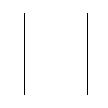

test4_395.jpg
DCGAN-tensorflow/data/barcode/test4_395.jpg


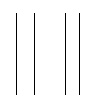

test3_63.jpg
DCGAN-tensorflow/data/barcode/test3_63.jpg


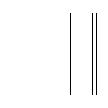

test1_1936.jpg
DCGAN-tensorflow/data/barcode/test1_1936.jpg


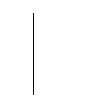

test2_42.jpg
DCGAN-tensorflow/data/barcode/test2_42.jpg


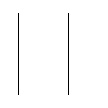

test4_1281.jpg
DCGAN-tensorflow/data/barcode/test4_1281.jpg


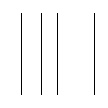

test3_294.jpg
DCGAN-tensorflow/data/barcode/test3_294.jpg


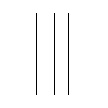

test4_1357.jpg
DCGAN-tensorflow/data/barcode/test4_1357.jpg


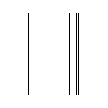

test4_1623.jpg
DCGAN-tensorflow/data/barcode/test4_1623.jpg


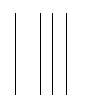

test1_763.jpg
DCGAN-tensorflow/data/barcode/test1_763.jpg


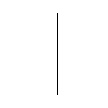

test1_1238.jpg
DCGAN-tensorflow/data/barcode/test1_1238.jpg


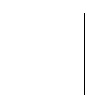

test3_174.jpg
DCGAN-tensorflow/data/barcode/test3_174.jpg


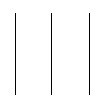

test2_774.jpg
DCGAN-tensorflow/data/barcode/test2_774.jpg


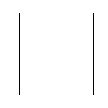

test5_399.jpg
DCGAN-tensorflow/data/barcode/test5_399.jpg


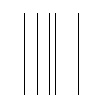

test3_1212.jpg
DCGAN-tensorflow/data/barcode/test3_1212.jpg


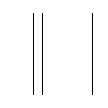

test2_1283.jpg
DCGAN-tensorflow/data/barcode/test2_1283.jpg


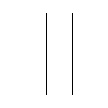

test3_636.jpg
DCGAN-tensorflow/data/barcode/test3_636.jpg


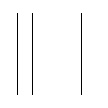

test1_980.jpg
DCGAN-tensorflow/data/barcode/test1_980.jpg


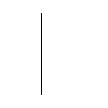

test2_18.jpg
DCGAN-tensorflow/data/barcode/test2_18.jpg


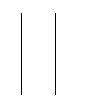

test2_1229.jpg
DCGAN-tensorflow/data/barcode/test2_1229.jpg


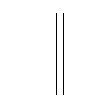

In [4]:
for file in fn[:20]:
    print(file)
    path = 'DCGAN-tensorflow/data/barcode/' + file
    print(path)
    display(Image(path))


In [14]:
image_size = 108
pixel_depth = 255.0
# put all the images into this blob of size 10kx108x108x3
dataset = np.ndarray(shape = (10000, 108, 108, 1), dtype = np.float32)
counter = 0
training_label = np.ndarray(shape = (10000), dtype = np.int64)
for file in fn:
    image_data = (ndimage.imread("DCGAN-tensorflow/data/barcode/"+file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
    if image_data.shape != (108, 108, 3):
        print("wrong size")
#     print(file[4])
    training_label[counter] = int(file[4])
    dataset[counter, :, :] = image_data[:,:,0:1]
    counter+=1
training_image, training_label = tf.sg_data._data_to_tensor([dataset, training_label], batch_size, name = "train")

In [12]:
training_image

<tf.Tensor 'train_5:0' shape=(32, 108, 108, 1) dtype=float32>

In [15]:
training_label

<tf.Tensor 'train_7:1' shape=(32,) dtype=int64>

[[ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]
 [ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]
 [ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]
 ..., 
 [ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]
 [ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]
 [ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]]
[4 8 4 9 1 3 1 5 5 4 6 3 7 3 5 3 1 1 4 2 7 7 6 4 9 2 9 0 3 9 6 4]


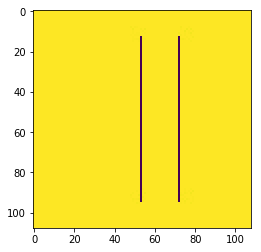

In [21]:
#shuffle
permutation = np.random.permutation(10000)
dataset = dataset[permutation, :, :]
training_label = training_label[permutation]
####START building the graph
# an array of 1 as label for G-D network. The output of the G-D should be all 1 ideally (G fools D all the time)
y = tf.ones(batch_size, dtype=tf.float32)
# half 1 and half 0. The output of D ideally should have half 1 and half 0 because it receive half authentic and half fake
y_disc = tf.concat([y, y*0], 0) #axis 0 means extending the vector

# GENERATE NOISE for G
# SHOULD HAVE THE SHAPE OF 32X(10+40). 2 of the 40 would be c1 and c2 as in INFO-GAN
# the categorical is one-hot encoding
# TODO: maybe change it to regression problem for arithmetic-GAN?
# generate c1 array
# tf.ones((batch_size, num_category))
sess = tf.InteractiveSession()

# TEST few example to see if it's working
sample_image = dataset[3, :, :]
print(sample_image)
plt.figure()
plt.imshow(sample_image)

tmp = tf.ones((batch_size, num_category), dtype=tf.float32)
z_cat = tf.multinomial(tf.ones((batch_size, num_category), dtype=tf.float32) / num_category, 1)
z_cat = tf.squeeze(z_cat)# no need to change to int
print(z_cat.eval())



In [22]:
# z has the shape of 32*(10+2+38)
z = z_cat.sg_one_hot(depth=num_category).sg_concat(target=tf.random_uniform((batch_size, num_dim-num_category)))
z

<tf.Tensor 'ConcatV2_1:0' shape=(32, 50) dtype=float32>

In [23]:
# random continuous variable (c1 and c2)
z_cont = z[:, num_category:num_category+num_cont]
z_cont

<tf.Tensor 'strided_slice_1:0' shape=(32, 2) dtype=float32>

In [24]:
training_batch_label = tf.placeholder(tf.int64, shape = (batch_size))
training_batch_data = tf.placeholder(tf.float32, shape = (batch_size, 108, 108, 1))
label = tf.concat([training_batch_label, z_cat], 0)
print(label)
training_batch_data

Tensor("concat_4:0", shape=(64,), dtype=int64)


<tf.Tensor 'Placeholder_3:0' shape=(32, 108, 108, 1) dtype=float32>

In [25]:
#G graph
# generator network
with tf.sg_context(name='generator1', size=4, stride=2, act='relu', bn=True):
    gen = (z.sg_dense(dim=1024)
           .sg_dense(dim=27*27*128)
           .sg_reshape(shape=(-1, 27, 27, 128))
           .sg_upconv(dim=64)
           .sg_upconv(dim=1, act='sigmoid', bn=False))

tf.sg_summary_image(gen)
gen

<tf.Tensor 'generator1_1/upconv_4/out:0' shape=(?, 108, 108, 1) dtype=float32>

In [26]:
real_fake_input = tf.concat([training_batch_data, gen], 0)
# D graph
# D graph will output C and true/fake (2 heads)
with tf.sg_context(name='discriminator1', size=4, stride=2, act='leaky_relu'):
    # shared part
    shared = (real_fake_input.sg_conv(dim=64)
              .sg_conv(dim=128)
              .sg_flatten()
              .sg_dense(dim=1024))
    # shared recognizer part
    recog_shared = shared.sg_dense(dim=128)
    # discriminator end (true/ fake), shape = (?, 1)
    disc = shared.sg_dense(dim=1, act='linear').sg_squeeze()
    # categorical recognizer end (c0), shape = (?, 10)
    recog_cat = recog_shared.sg_dense(dim=num_category, act='linear')
    # continuous recognizer end (c1 and c2), shape=(?, 2)
    recog_cont = recog_shared[batch_size:, :].sg_dense(dim=num_cont, act='sigmoid')
    # we dont care about the rest of the output of D


In [27]:
# # GD network. The only output is the discriminator head
# GD = disc.sg_reuse(input = gen)
# GD

In [28]:
# loss of the D network
# loss of the discriminator head
loss_disc = tf.reduce_mean(disc.sg_bce(target = y_disc))
# loss of the C head (calculating loss of all c0, c1, c2)
loss_recog = tf.reduce_mean(recog_cat.sg_ce(target=label)) \
             + tf.reduce_mean(recog_cont.sg_mse(target=z_cont))
# IMPORTANT
# essentially creating the G+D network here, by using sg_reuse
loss_gen = tf.reduce_mean(disc.sg_reuse(input = gen).sg_bce(target = y))

train_disc = tf.sg_optim(loss_disc + loss_recog, lr=0.0001, category='discriminator1')  # discriminator train ops
train_gen = tf.sg_optim(loss_gen + loss_recog, lr=0.001, category='generator1')

ValueError: None values not supported.